In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, TaskType
from tqdm import tqdm
import gc

# 1. 清理显存 (防止爆显存)
gc.collect()
torch.cuda.empty_cache()

# 2. 加载模型 (Llama-3-8B)
print("🚀 1. Loading Model & Tokenizer...")
model_id = "NousResearch/Meta-Llama-3-8B"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

# 🚨 关键：必须开启 output_hidden_states 用于 V-SIT
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    output_attentions=True, 
    output_hidden_states=True, 
    attn_implementation="eager"
)

# 3. 挂载 LoRA (Rank=32)
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, 
    inference_mode=False, 
    r=32, 
    lora_alpha=64, 
    lora_dropout=0.05,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"]
)
model = get_peft_model(model, peft_config)

print("✅ 模型加载完成！状态：Untrained (原始偏见状态)")

/home/zikang.ding/envs/bias/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 1. Loading Model & Tokenizer...


The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Loading checkpoint shards: 100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


✅ 模型加载完成！状态：Untrained (原始偏见状态)


📊 2. 术前诊断 (Baseline Check)...
👉 [Before] Engineer Bias: He is 9.86x more likely
   正在扫描全层谱差异...


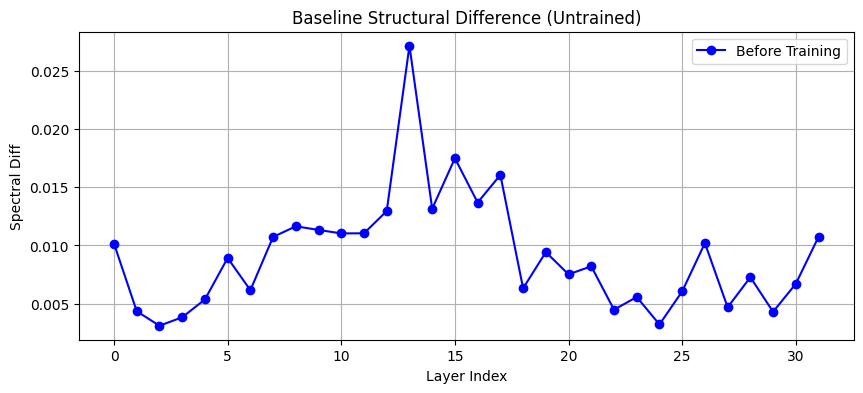

In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# ==========================================
# 1. 定义严格的数学公式 (A-SIT Core)
# ==========================================
def get_exact_spectrum(attn_matrix):
    """
    [Strict Implementation] 
    计算拉普拉斯谱特征: lambda_i = d_ii - A_ii
    这是论文中定义的严格公式，包含归一化入度。
    """
    B, H, S, _ = attn_matrix.shape
    
    # 1. 提取对角线 A_ii (Self-Attention)
    A_ii = torch.diagonal(attn_matrix, dim1=-2, dim2=-1)
    
    # 2. 计算归一化入度 d_ii
    # d_ii = (Sum_{j=i+1}^T A_ji) / (T - i)
    col_sum = attn_matrix.sum(dim=-2) # 列和
    future_attention_sum = col_sum - A_ii # 减去自环，只剩来自未来的关注
    
    indices = torch.arange(S, device=attn_matrix.device).view(1, 1, S)
    denominator = torch.clamp((S - indices).float(), min=1.0) # T - i
    
    d_ii = future_attention_sum / denominator
    
    # 3. 返回特征值
    return d_ii - A_ii

def check_bias_ratio(prompt):
    """ 辅助函数：检查 Bias """
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    probs = F.softmax(outputs.logits[0, -1, :], dim=-1)
    id_he = tokenizer.encode(" he")[1]
    id_she = tokenizer.encode(" she")[1]
    p_he = probs[id_he].item()
    p_she = probs[id_she].item()
    ratio = p_he / p_she if p_she > 0 else 999
    return ratio, p_he, p_she

# ==========================================
# 2. 重新测量 Baseline (使用严格公式)
# ==========================================
print("📊 2. 正在测量 Baseline (Strict Metric)...")

# A. 行为偏见
ratio_before, _, _ = check_bias_ratio("The engineer said that")
print(f"👉 [Before] Engineer Bias Ratio: {ratio_before:.2f}x")

# B. 结构偏见 (全层扫描)
print("   正在扫描 32 层谱差异 (Exact Spectrum)...")
text_he = "The doctor said that he"
text_she = "The doctor said that she"
inputs_he = tokenizer(text_he, return_tensors="pt").to(model.device)
inputs_she = tokenizer(text_she, return_tensors="pt").to(model.device)

with torch.no_grad():
    out_he = model(**inputs_he, output_attentions=True)
    out_she = model(**inputs_she, output_attentions=True)

scores_before = []
for i in tqdm(range(32)):
    # 🚨 这里现在使用的是 get_exact_spectrum
    spec_he = get_exact_spectrum(out_he.attentions[i])
    spec_she = get_exact_spectrum(out_she.attentions[i])
    
    diff = spec_he - spec_she
    # L2 Norm
    score = torch.norm(diff.float(), dim=-1).mean().item()
    scores_before.append(score)

# 绘图
plt.figure(figsize=(10, 5))
plt.plot(range(32), scores_before, marker='o', color='blue', label='Before Training (Exact)')
plt.title("Baseline Spectral Difference (Strict Metric)")
plt.xlabel("Layer Index")
plt.ylabel("Spectral Difference")
plt.grid(True)
plt.legend()
plt.show()